# Flight delays

For our final project of our Masters of Financial Engineering (MFE) class at Berkeley we designed an application that will predict flight delays a day in advance. 

We implemented all steps from problem formulation, to data collection, cleaning/preparation, feature engineering and model development. We also thought through what would be needed for model deployment (more high level)

After extensive feature engineering, we evaluated RandomForest, XGBoost, Logistic Regression and a Recurrent Neural Network. Feature engineering proved the most effective in terms of improving performance. The RNN helped boost performance further and seemed to be able to capture the spatial, temporal and other patterns best.

Our paper can be found on [SSRN: Flight Delays](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3060118)

In [1]:
import pymc as pm
import seaborn as sns
import numpy as np
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
%matplotlib inline
from pandas import read_excel
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [2]:
import codecs
from bs4 import BeautifulSoup
import re
import gzip
import os
import pandas as pd
from numba import jit
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import csv

In [3]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

1.Get Data

In [4]:
lat_lon_data_df = read_excel("Data/Lat_Lon_data.xlsx")
seat_data_df = read_excel("Data/TailNum_Seats_Lookup.xls")
weather_data  = pd.read_csv("Data/Weather_Data.csv")

In [5]:
import pandas as pd
import zipfile
file_list = os.listdir("C:\\Users\\MBAUser\\Desktop\\ServerTwo_Python\\Flight_delays\\Data\\flights_data")

for i, onefile in enumerate(file_list):
    filename = onefile.split('.')[0] +".csv"
    zf = zipfile.ZipFile("C:\\Users\\MBAUser\\Desktop\\ServerTwo_Python\\Flight_delays\\Data\\flights_data\\%s" %onefile) 
    if i == 0:
        flight_data_df_temp = pd.read_csv(zf.open(filename),low_memory=False)
        #flight_data_df_temp['CRSDepTime'] = round(flight_data_df_temp['CRSDepTime']/100)
        #flight_data_df_temp['CRSArrTime'] = round(flight_data_df_temp['CRSArrTime']/100)

        flight_data_df_temp = flight_data_df_temp.iloc[:,:60]
        flight_data_df = pd.merge(flight_data_df_temp, lat_lon_data_df,how='left', \
                            left_on=['Dest'], right_on = ['IATA'], suffixes=('','_dest'))
        flight_data_df = pd.merge(flight_data_df, weather_data,how='left', \
                            left_on=['Year','Month','DayofMonth','City'], right_on =['Year','Month','Day','City'], \
                           suffixes=('','_weather'))

    else:
        flight_data_df_temp = pd.read_csv(zf.open(filename),low_memory=False)
        #flight_data_df_temp['CRSDepTime'] = round(flight_data_df_temp['CRSDepTime']/100)
        #flight_data_df_temp['CRSArrTime'] = round(flight_data_df_temp['CRSArrTime']/100)
        
        flight_data_df_temp = flight_data_df_temp.iloc[:,:60]
        flight_data_df_temp = pd.merge(flight_data_df_temp, lat_lon_data_df,how='left', \
                            left_on=['Dest'], right_on = ['IATA'], suffixes=('','_dest'))
        flight_data_df_temp = pd.merge(flight_data_df_temp, weather_data,how='left', \
                            left_on=['Year','Month','DayofMonth','City'], right_on =['Year','Month','Day','City'], \
                           suffixes=('','_weather'))
        flight_data_df = pd.concat([flight_data_df,flight_data_df_temp],axis=0) 
    

In [6]:
flight_data_df.shape

(5638404, 95)

In [7]:
flight_data_df.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'UniqueCarrier', 'AirlineID', 'Carrier', 'TailNum', 'FlightNum',
       'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin',
       'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName',
       'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID',
       'Dest', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName',
       'DestWac', 'CRSDepTime', 'DepTime', 'DepDelay', 'DepDelayMinutes',
       'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut',
       'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay',
       'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk',
       'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'Flights', 'Distance', 'DistanceGroup',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'Airport ID', 'Name'

In [8]:
airport_delay = flight_data_df.groupby(['Year', 'Quarter', 'Month', 'DayofMonth','AirlineID']).mean()[['ArrDelay']]

airport_delay.reset_index(inplace=True) 

airport_delay['DayofMonth'].apply(lambda x: x - 1 if x!=1 else 30)

for row in range(airport_delay.shape[0]):
    if airport_delay['DayofMonth'][row] == 1:
        airport_delay['Month'][row] =  airport_delay['Month'][row] - 1
        
flight_data_df1 = flight_data_df.merge(airport_delay.reset_index(), \
                    on = ['Year', 'Quarter', 'Month', 'DayofMonth', 'AirlineID'], how='left', suffixes=('', '_avg_airline'))

flight_data_df = flight_data_df1

In [9]:
airport_delay = flight_data_df.groupby(['Year', 'Quarter', 'Month', 'DayofMonth','AirlineID']).mean()[['DepDelay']]

airport_delay.reset_index(inplace=True) 

airport_delay['DayofMonth'].apply(lambda x: x - 1 if x!=1 else 30)

for row in range(airport_delay.shape[0]):
    if airport_delay['DayofMonth'][row] == 1:
        airport_delay['Month'][row] =  airport_delay['Month'][row] - 1
        
flight_data_df2 = flight_data_df.merge(airport_delay.reset_index(), \
                    on = ['Year', 'Quarter', 'Month', 'DayofMonth', 'AirlineID'], how='left',suffixes=('', '_avg_airline'))

flight_data_df = flight_data_df2

In [10]:
airport_delay = flight_data_df.groupby(['Year', 'Quarter', 'Month', 'DayofMonth','DestCityName']).mean()[['ArrDelay']]

airport_delay.reset_index(inplace=True) 

airport_delay['DayofMonth'].apply(lambda x: x - 1 if x!=1 else 30)

for row in range(airport_delay.shape[0]):
    if airport_delay['DayofMonth'][row] == 1:
        airport_delay['Month'][row] =  airport_delay['Month'][row] - 1
        
flight_data_df3 = flight_data_df.merge(airport_delay.reset_index(), \
                    on = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DestCityName'], how='left',suffixes=('', '_avg_dest'))

flight_data_df = flight_data_df3

In [11]:
airport_delay = flight_data_df.groupby(['Year', 'Quarter', 'Month', 'DayofMonth','OriginCityName']).mean()[['DepDelay']]

airport_delay.reset_index(inplace=True) 

airport_delay['DayofMonth'].apply(lambda x: x - 1 if x!=1 else 30)

for row in range(airport_delay.shape[0]):
    if airport_delay['DayofMonth'][row] == 1:
        airport_delay['Month'][row] =  airport_delay['Month'][row] - 1
        
flight_data_df4 = flight_data_df.merge(airport_delay.reset_index(), \
                    on = ['Year', 'Quarter', 'Month', 'DayofMonth', 'OriginCityName'], how='left',suffixes=('', '_avg_origin'))

flight_data_df = flight_data_df4

In [12]:
flight_data_df5 = flight_data_df.merge(seat_data_df, on = ['TailNum'], how='left',suffixes=('', '_seats'))

In [13]:
flight_data_df = flight_data_df5
flight_data_df.shape

(5638404, 104)

2.Understand Data

In [14]:
dest_city, dest_city_count = np.unique(flight_data_df['DestCityName'], return_counts=True)
dest_city_count_df = pd.DataFrame(np.vstack([dest_city, dest_city_count])).T
dest_city_count_df.columns = ['ID', 'Count'] 
dest_city_count_df = dest_city_count_df.sort_values(['Count'])
dest_city_count_df.index = dest_city_count_df['ID']
dest_city_count_df.columns = ['City', 'Count'] 

dest_state, dest_state_count = np.unique(flight_data_df['DestState'], return_counts=True)
dest_state_count_df = pd.DataFrame(np.vstack([dest_state, dest_state_count])).T
dest_state_count_df.columns = ['ID', 'Count']
dest_state_count_df = dest_state_count_df.sort_values(['Count'])
dest_state_count_df.index = dest_state_count_df['ID']
dest_state_count_df.columns = ['State', 'Count'] 

carrier, carrier_count = np.unique(flight_data_df['Carrier'], return_counts=True)
carrier_count_df = pd.DataFrame(np.vstack([carrier, carrier_count])).T
carrier_count_df.columns = ['ID', 'Count']
carrier_count_df = carrier_count_df.sort_values(['Count'])
carrier_count_df.index = carrier_count_df['ID']
carrier_count_df.columns = ['Carrier', 'Count']

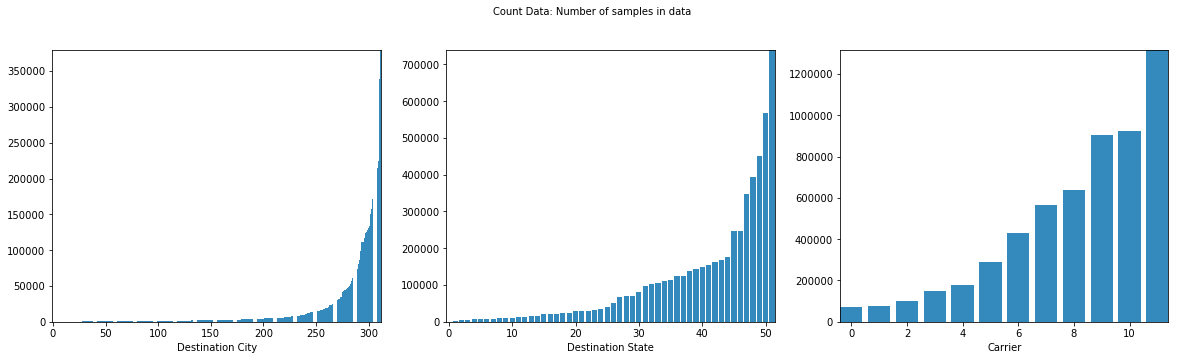

In [15]:
figsize(20, 5)
name_list = ['Destination City', 'Destination State', 'Carrier']
for i, tables in enumerate([dest_city_count_df,dest_state_count_df,carrier_count_df]):
    sx = plt.subplot(1, 3, i + 1)
    plt.bar(range(len(tables.index)), tables['Count'], color="#348ABD")
    #sx.set_xticklabels(tables.index, rotation='vertical', fontsize=10)
    plt.autoscale(tight=True) 
    plt.xlabel(name_list[i])

plt.suptitle('Count Data: Number of samples in data',y=1,fontsize=10)
plt.show()

In [16]:
top_cities = [dest_city_count_df['City'][::-1][:10]]

In [17]:
print ("Percentage of traffic in top 10 traffic cities")
flight_data_df[flight_data_df['DestCityName'].isin(top_cities)]['DestCityName'].count().sum()/\
flight_data_df['DestCityName'].shape[0]

Percentage of traffic in top 10 traffic cities


0.39086486175875301

In [18]:
print("US High Traffic:")
display(pd.concat([dest_city_count_df[::-1][:5],dest_city_count_df[:5][::-1]]))
display(pd.concat([dest_state_count_df[::-1][:5],dest_state_count_df[:5][::-1]]))
display(pd.concat([carrier_count_df[::-1][:5],carrier_count_df[:5][::-1]]))

US High Traffic:


,City,Count
ID,,
"Atlanta, GA","Atlanta, GA",379413
"Chicago, IL","Chicago, IL",339622
"Denver, CO","Denver, CO",224191
"Los Angeles, CA","Los Angeles, CA",215217
"New York, NY","New York, NY",190210
"Dillingham, AK","Dillingham, AK",85
"Toledo, OH","Toledo, OH",76
"King Salmon, AK","King Salmon, AK",64
"Sioux City, IA","Sioux City, IA",28


,State,Count
ID,,
CA,CA,739224
TX,TX,566547
FL,FL,450504
GA,GA,393625
IL,IL,348549
NH,NH,6388
VI,VI,6105
VT,VT,3798
WV,WV,2494


,Carrier,Count
ID,,
WN,WN,1315441
DL,DL,921391
AA,AA,901653
OO,OO,637964
UA,UA,564361
AS,AS,180344
NK,NK,147004
F9,F9,98728
HA,HA,77899


In [19]:
flight_data_df_old = flight_data_df
flight_data_df = flight_data_df[flight_data_df['DestCityName'].isin(top_cities)]

In [20]:
flight_data_df['ArrDelay'].sum()/flight_data_df['ArrDelay'].count()

5.8166938455312511

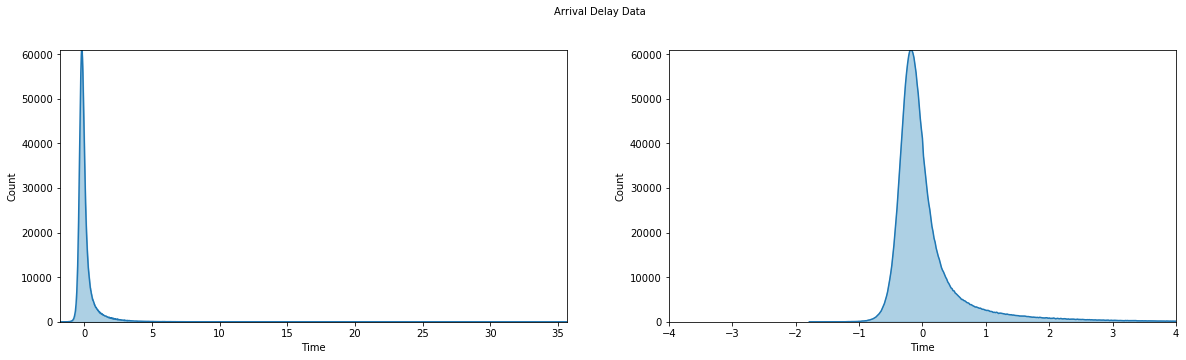

In [21]:
arr_delay_time_distribution_df = pd.DataFrame((flight_data_df['ArrDelay']/60).value_counts())
arr_delay_time_distribution_df['Time'] = arr_delay_time_distribution_df.index
arr_delay_time_distribution_df.columns = ['Count','Time']
arr_delay_time_distribution_df.index = range(arr_delay_time_distribution_df.shape[0])
arr_delay_time_distribution_df = arr_delay_time_distribution_df.sort_values(['Time'])

figsize(20, 5)
sx = plt.subplot(1, 2, 1)
plt.plot(arr_delay_time_distribution_df['Time'], arr_delay_time_distribution_df['Count'])
plt.autoscale(tight=True) 
plt.fill_between(arr_delay_time_distribution_df['Time'], 0, arr_delay_time_distribution_df['Count'], color="#348ABD", alpha=0.4)
plt.xlabel("Time")
plt.ylabel("Count")

sx = plt.subplot(1, 2, 2)
plt.plot(arr_delay_time_distribution_df['Time'],arr_delay_time_distribution_df['Count'])
plt.autoscale(tight=True) 
plt.fill_between(arr_delay_time_distribution_df['Time'], 0, arr_delay_time_distribution_df['Count'], color="#348ABD", alpha=0.4)
plt.xlabel("Time")
plt.ylabel("Count")
plt.xlim([-4,4])

plt.suptitle('Arrival Delay Data',y=1,fontsize=10)

In [22]:
print("Percentage - Arrival delay which is more than 15mins : %.2f"
      %round(float(flight_data_df['ArrDel15'].sum()/flight_data_df['ArrDel15'].count()),2))

Percentage - Arrival delay which is more than 15mins : 0.20


In [23]:
countdelay_m15_0 = arr_delay_time_distribution_df[(arr_delay_time_distribution_df['Time']<=0) & \
                                                  (arr_delay_time_distribution_df['Time']>=-15)].sum()[0]
countdelay_total = arr_delay_time_distribution_df.sum()[0]
print("Percentage - Arrival delay between -15 mins and 0 mins: %.2f" %round(float(countdelay_m15_0/countdelay_total),2))

Percentage - Arrival delay between -15 mins and 0 mins: 0.64


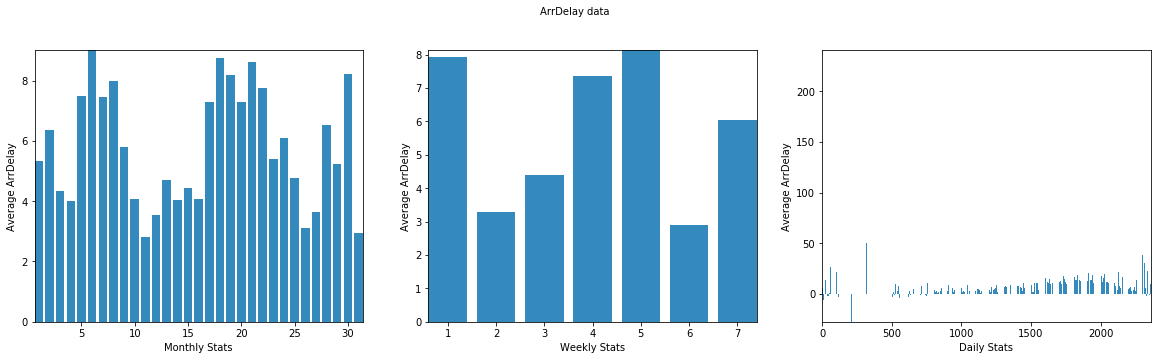

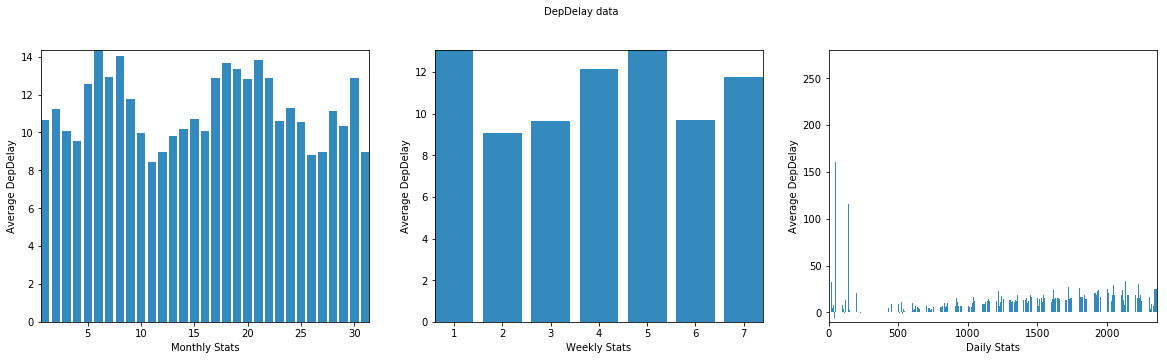

In [24]:
daily_delay_dict = {}

for type_of in ['ArrDelay', 'DepDelay']: 
    figsize(20, 5)
    name_list = ['Monthly Stats', 'Weekly Stats', 'Daily Stats']
    col_list = ['DayofMonth', 'DayOfWeek', 'CRSDepTime']

    for i, colum in enumerate(col_list):    
        table = flight_data_df.groupby([colum]).mean()
        table = table.sort_index()
        sx = plt.subplot(1, 3, i + 1)
        plt.bar(table.index, table[type_of], color="#348ABD")
        if i == 2:
            daily_delay_dict[type_of] = table[type_of]
        plt.autoscale(tight=True) 
        plt.xlabel(name_list[i])
        plt.ylabel('Average %s' %type_of)
    
    plt.suptitle('%s data' %type_of,y=1,fontsize=10)
    plt.show()
    

In [25]:
display(pd.concat([pd.DataFrame(daily_delay_dict['ArrDelay']).sort_values(['ArrDelay'])[::-1].iloc[:5,:], \
          pd.DataFrame(daily_delay_dict['ArrDelay']).sort_values(['ArrDelay']).iloc[:5,:]]))

display(pd.concat([pd.DataFrame(daily_delay_dict['DepDelay']).sort_values(['DepDelay'])[::-1].iloc[:5,:], \
          pd.DataFrame(daily_delay_dict['DepDelay']).sort_values(['DepDelay']).iloc[:5,:]]))

,ArrDelay
CRSDepTime,
457,241.00
49,193.25
143,94.50
327,70.50
2321,55.33
210,-27.67
313,-27.00
2314,-25.65
443,-25.00


,DepDelay
CRSDepTime,
457,280.00
49,160.20
143,115.25
327,77.50
318,63.00
516,-10.00
340,-7.16
109,-7.00
2314,-6.33


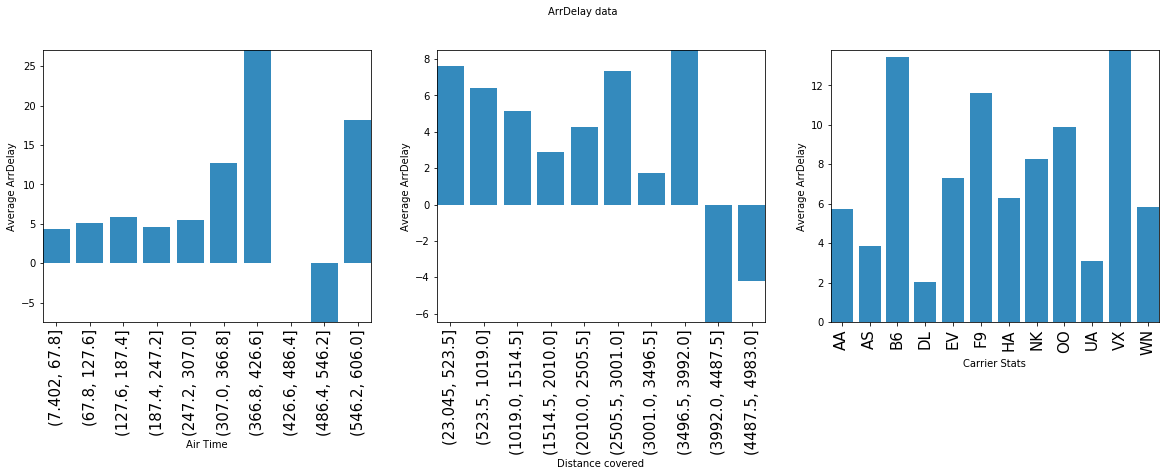

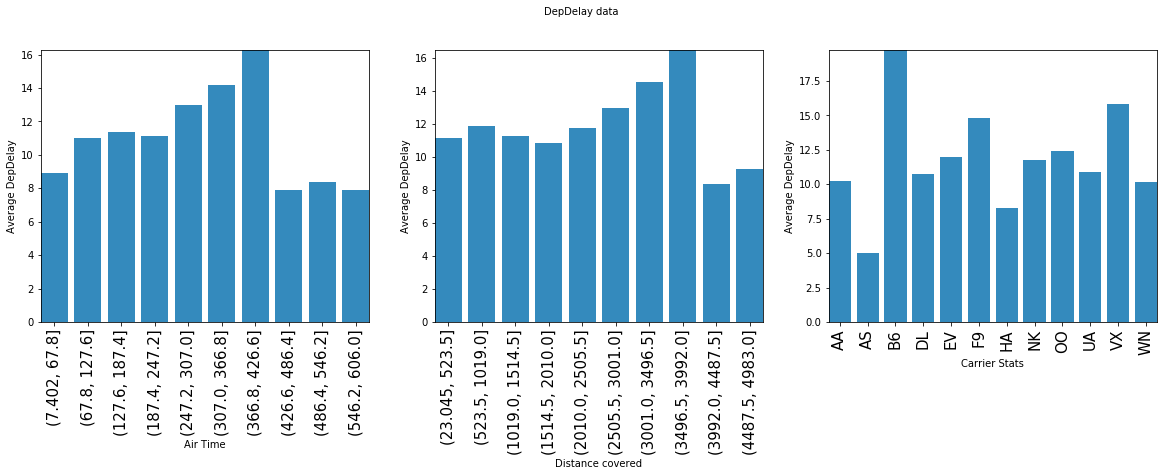

In [26]:
carrier_delay_dict = {}

for type_of in ['ArrDelay', 'DepDelay']: 
    figsize(20, 5)
    
    name_list = ['Air Time', 'Distance covered', 'Carrier Stats']
    col_list = ['AirTime', 'Distance', 'Carrier']

    for i, colum in enumerate(col_list):    
        table = flight_data_df.groupby([colum]).mean()
        table = table[[type_of]]        
        
        if i < 2:
            table['range'] = pd.cut(table.index,10)
            table = table.groupby('range').mean()
        
        sx = plt.subplot(1, 3, i + 1)
        plt.bar(range(len(table.index)), table[type_of], color="#348ABD")
        plt.xticks(range(len(table.index)))
        sx.set_xticklabels(table.index, rotation='vertical', fontsize=15)
        
        if i == 2:
            carrier_delay_dict[type_of] = table[type_of]
        
        plt.autoscale(tight=True) 
        plt.xlabel(name_list[i])
        plt.ylabel('Average %s' %type_of)
    
    plt.suptitle('%s data' %type_of,y=1,fontsize=10)
    plt.show()        


In [27]:
display(pd.concat([pd.DataFrame(carrier_delay_dict['ArrDelay']).sort_values(['ArrDelay'])[::-1].iloc[:5,:], \
          pd.DataFrame(carrier_delay_dict['ArrDelay']).sort_values(['ArrDelay']).iloc[:5,:][::-1]]))

display(pd.concat([pd.DataFrame(carrier_delay_dict['DepDelay']).sort_values(['DepDelay'])[::-1].iloc[:5,:], \
          pd.DataFrame(carrier_delay_dict['DepDelay']).sort_values(['DepDelay']).iloc[:5,:][::-1]]))

,ArrDelay
Carrier,
VX,13.78
B6,13.43
F9,11.62
OO,9.88
NK,8.28
WN,5.81
AA,5.74
AS,3.85
UA,3.08


,DepDelay
Carrier,
B6,19.74
VX,15.84
F9,14.82
OO,12.42
EV,12.00
DL,10.75
AA,10.24
WN,10.18
HA,8.26


In [28]:
east_flight_data_df = flight_data_df[flight_data_df['Longitude'] > - 98.35]
west_flight_data_df = flight_data_df[flight_data_df['Longitude'] < - 98.35]
side =  ['East', 'West']

In [29]:
ew_data = [flight_data_df]

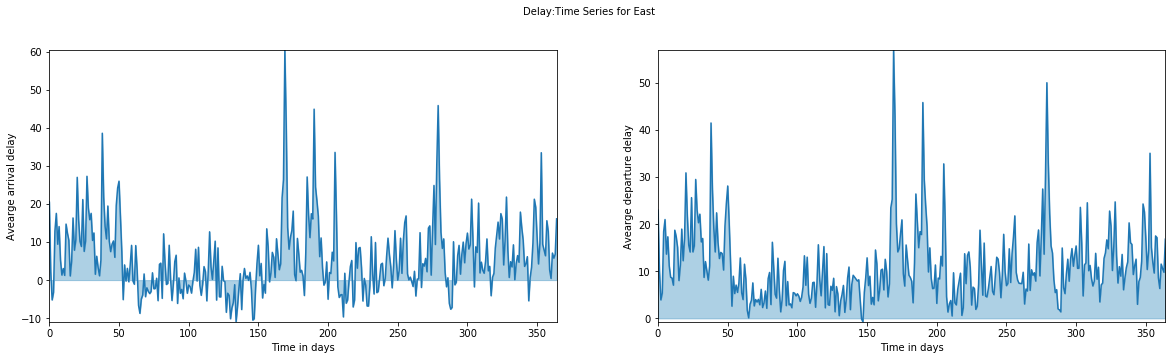

In [30]:
for i, data in enumerate(ew_data):
    
    arrtime_delay = data.groupby(['Year','Month','DayofMonth']).mean()['ArrDelay']
    deptime_delay = data.groupby(['Year','Month','DayofMonth']).mean()['DepDelay']
    
    figsize(20, 5)
    sx = plt.subplot(1, 2, 1)
    plt.plot(range(len(arrtime_delay)), arrtime_delay)
    plt.autoscale(tight=True) 
    plt.fill_between(range(len(arrtime_delay)), 0, arrtime_delay, color="#348ABD", alpha=0.4)
    plt.xlabel("Time in days")
    plt.ylabel("Avearge arrival delay")
    
    sx = plt.subplot(1, 2, 2)
    plt.plot(range(len(deptime_delay)), deptime_delay)
    plt.autoscale(tight=True) 
    plt.fill_between(range(len(deptime_delay)), 0, deptime_delay, color="#348ABD", alpha=0.4)
    plt.xlabel("Time in days")
    plt.ylabel("Avearge departure delay")

    plt.suptitle('Delay:Time Series for %s' %side[i], y=1, fontsize=10)
    plt.show()

In [31]:
def plot_weather(longitude, latitude, delay_plots_df, delaytype):
    figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))

    m = Basemap(
                ax=axes,
                projection='cyl',
                lon_0=longitude, lat_0=latitude,
                llcrnrlat=latitude - 20.0, urcrnrlat=latitude + 20.0,
                llcrnrlon=longitude - 30.0, urcrnrlon=longitude + 30.0,
                resolution='i'
                )


    m.fillcontinents(color='white', alpha = 0.1,lake_color='aqua')

    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawstates()
    
    lons = delay_plots_df['Longitude']
    lats = delay_plots_df['Latitude']
 
    x, y = m(delay_plots_df['Longitude'], delay_plots_df['Latitude'])
   
    s = [int(row)*4 for row in delay_plots_df[delaytype]]
    plt.scatter(x, y, s=s, alpha=0.1, edgecolor='none')
    plt.title('%s across the USA for July 2016 - July 2017' %delaytype)
    plt.show()


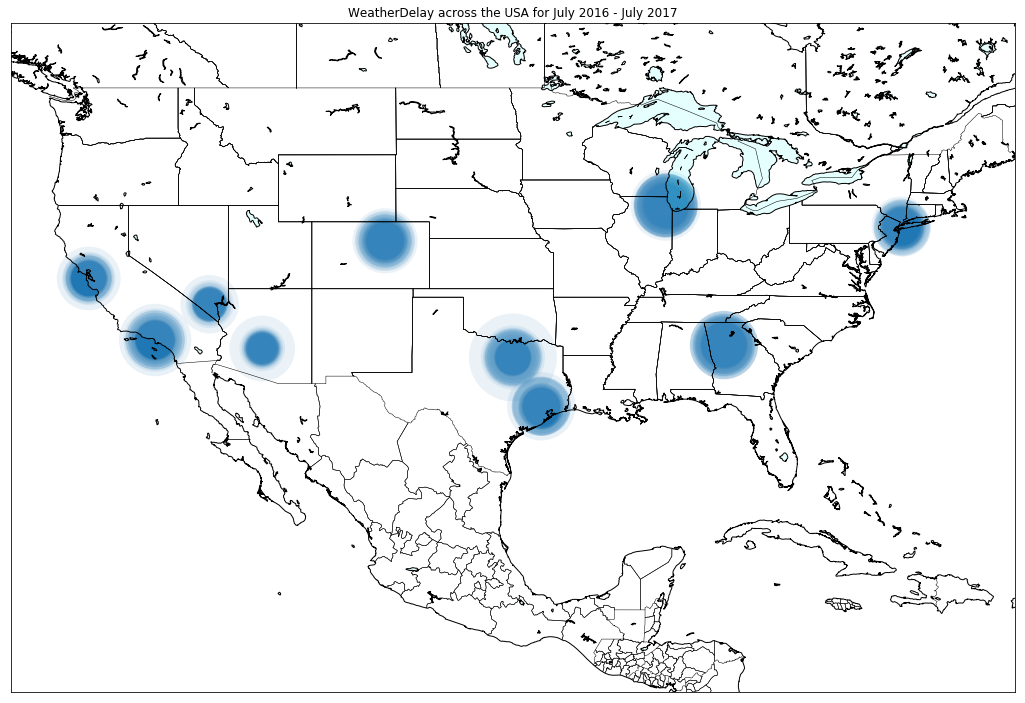

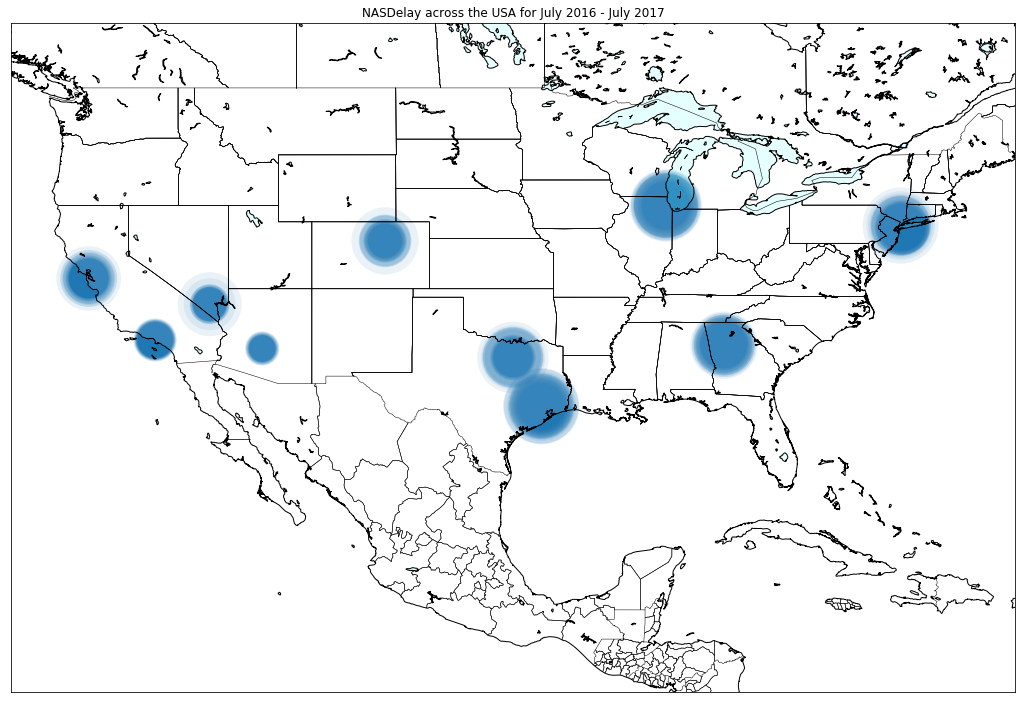

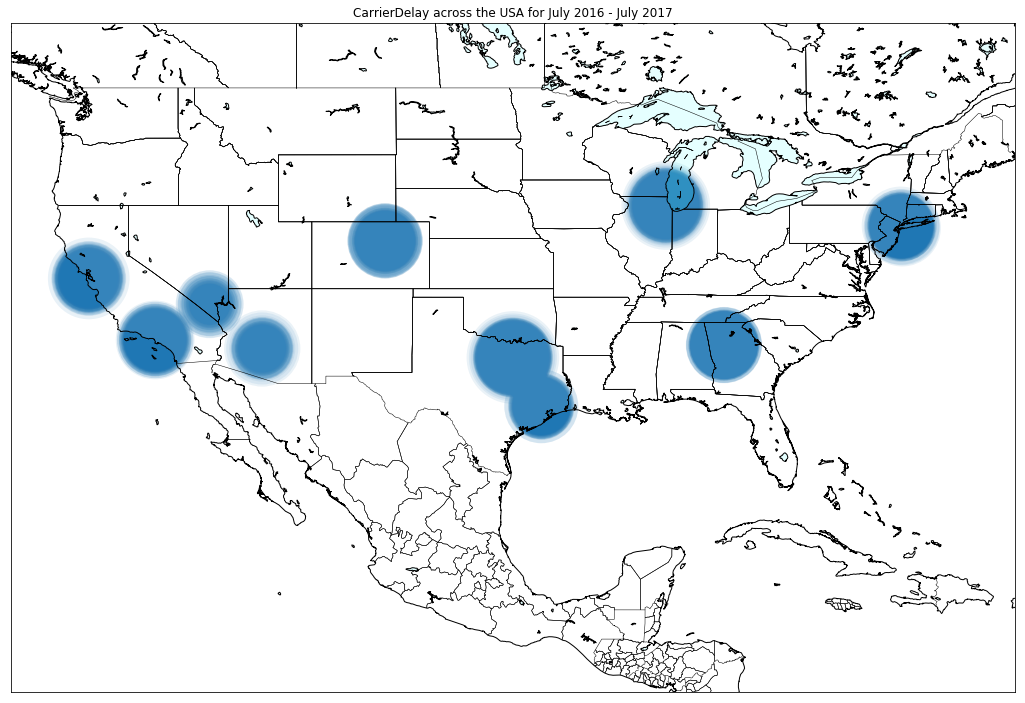

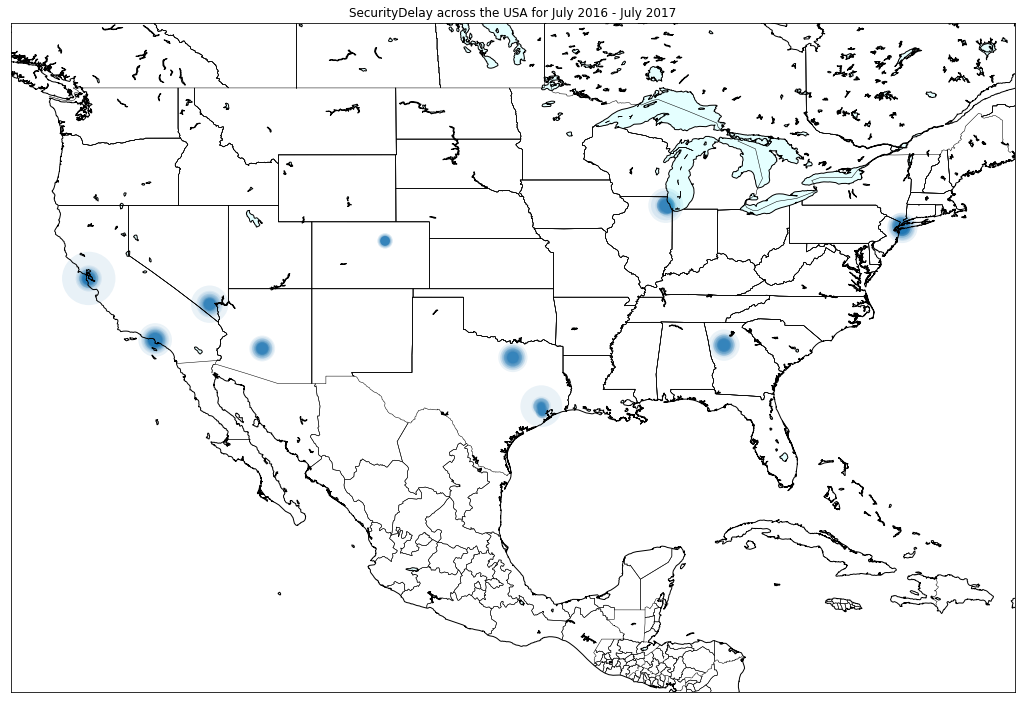

In [32]:
delay_plots_df = flight_data_df2[['Longitude','Latitude','WeatherDelay']].dropna()
#delay_plots_df['WeatherDelay'] = delay_plots_df['WeatherDelay'].apply(lambda x: 1 if x>0 else 0)
plot_weather(-97.0372,32.895951, delay_plots_df, delaytype = 'WeatherDelay')
delay_plots_df = flight_data_df2[['Longitude','Latitude','NASDelay']].dropna()
#delay_plots_df['NASDelay'] = delay_plots_df['NASDelay'].apply(lambda x: 1 if x>0 else 0)
plot_weather(-97.0372,32.895951, delay_plots_df, delaytype =  'NASDelay')
delay_plots_df = flight_data_df2[['Longitude','Latitude','CarrierDelay']].dropna()
#delay_plots_df['WeatherDelay'] = delay_plots_df['WeatherDelay'].apply(lambda x: 1 if x>0 else 0)
plot_weather(-97.0372,32.895951, delay_plots_df, delaytype = 'CarrierDelay')
delay_plots_df = flight_data_df2[['Longitude','Latitude','SecurityDelay']].dropna()
#delay_plots_df['NASDelay'] = delay_plots_df['NASDelay'].apply(lambda x: 1 if x>0 else 0)
plot_weather(-97.0372,32.895951, delay_plots_df, delaytype =  'SecurityDelay')

### 3.Preparing data

In [14]:
flight_data_df2 = flight_data_df[flight_data_df['City'] == 'New York']

In [131]:
remove = ['DepDelayMinutes', 'DepartureDelayGroups', 'DepTimeBlk', 
          'WheelsOff', 'WheelsOn', 
          'OriginAirportSeqID', 'OriginCityMarketID', 'DestAirportSeqID', 'DestCityMarketID',
           'ArrDelayMinutes', 'ArrivalDelayGroups', 'ArrTimeBlk',
           'Cancelled', 'CancellationCode', 'Diverted', 
          'CRSElapsedTime','ActualElapsedTime', 'AirTime', 'Distance', 'Day', 'State',
          'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
        'index_avg_dest', 'index_avg_origin', 'index_avg_airline', 'index']
data_1 = flight_data_df2.drop(remove, axis=1)

remove2 = ['FlightDate', 'AirlineID', 'UniqueCarrier', 'TailNum','OriginAirportID', 'DestAirportID','Origin', 'Dest',
           'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestStateFips', 'DestStateName','DestWac',
          'DepTime', 'DepDel15', 'ArrTime','IATA','ICAO', 'Flights',
          'Airport ID', 'Name', 'City', 'Country','DST']

data = data_1.drop(remove2, axis=1)

In [132]:
data.shape, data.columns

((190210, 50),
 Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier',
        'FlightNum', 'OriginCityName', 'OriginState', 'DestCityName',
        'DestState', 'CRSDepTime', 'DepDelay', 'TaxiOut', 'TaxiIn',
        'CRSArrTime', 'ArrDelay', 'ArrDel15', 'DistanceGroup', 'Latitude',
        'Longitude', 'Altitude', 'Timezone', 'Temp. (°F) high',
        'Temp. (°F) avg', 'Temp. (°F) low', 'Dew Point (°F) high',
        'Dew Point (°F) avg', 'Dew Point (°F) low', 'Humidity (%) high',
        'Humidity (%) avg', 'Humidity (%) low', 'Sea Level Press. (in) high',
        'Sea Level Press. (in) avg', ' Sea Level Press. (in) low',
        'Visibility (mi) high', 'Visibility (mi) avg', 'Visibility (mi) low',
        'Wind (mph) high', 'Wind (mph) avg', 'Wind (mph) low', 'Precip. (in)',
        'rain', 'fog', 'snow', 'ArrDelay_avg_airline', 'DepDelay_avg_airline',
        'ArrDelay_avg_dest', 'DepDelay_avg_origin', 'Seats'],
       dtype='object'))

In [133]:
data = data.dropna()
data.shape, data.columns

((133407, 50),
 Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier',
        'FlightNum', 'OriginCityName', 'OriginState', 'DestCityName',
        'DestState', 'CRSDepTime', 'DepDelay', 'TaxiOut', 'TaxiIn',
        'CRSArrTime', 'ArrDelay', 'ArrDel15', 'DistanceGroup', 'Latitude',
        'Longitude', 'Altitude', 'Timezone', 'Temp. (°F) high',
        'Temp. (°F) avg', 'Temp. (°F) low', 'Dew Point (°F) high',
        'Dew Point (°F) avg', 'Dew Point (°F) low', 'Humidity (%) high',
        'Humidity (%) avg', 'Humidity (%) low', 'Sea Level Press. (in) high',
        'Sea Level Press. (in) avg', ' Sea Level Press. (in) low',
        'Visibility (mi) high', 'Visibility (mi) avg', 'Visibility (mi) low',
        'Wind (mph) high', 'Wind (mph) avg', 'Wind (mph) low', 'Precip. (in)',
        'rain', 'fog', 'snow', 'ArrDelay_avg_airline', 'DepDelay_avg_airline',
        'ArrDelay_avg_dest', 'DepDelay_avg_origin', 'Seats'],
       dtype='object'))

In [134]:
final_data = data
final_data = final_data.sort_values(['Year', 'Month','DayofMonth','CRSArrTime','CRSDepTime'])
final_data.shape

(133407, 50)

In [142]:
data_for_rnn1 = final_data[['ArrDelay', 'DepDelay', 'TaxiOut', 'TaxiIn']]
data_for_rnn1.columns = ['ArrDelaylag', 'DepDelaylag', 'TaxiOutlag', 'TaxiInlag']
data_for_rnn2 = final_data[['ArrDel15','ArrDelay_avg_airline', 'DepDelay_avg_airline',
                    'ArrDelay_avg_dest', 'DepDelay_avg_origin',
                    'Temp. (°F) high','Temp. (°F) avg', 'Temp. (°F) low', 'Dew Point (°F) high',
                    'Dew Point (°F) avg', 'Dew Point (°F) low', 'Humidity (%) high',
                    'Humidity (%) avg', 'Humidity (%) low', 'Sea Level Press. (in) high',
                    'Sea Level Press. (in) avg', ' Sea Level Press. (in) low',
                    'Visibility (mi) high', 'Visibility (mi) avg', 'Visibility (mi) low',
                    'Wind (mph) high', 'Wind (mph) avg', 'Wind (mph) low', 'Precip. (in)']]

data_for_rnn2 =  data_for_rnn2.apply(pd.to_numeric, errors='coerce')

data_for_rnn1 = data_for_rnn1[:-1]
data_for_rnn2 = data_for_rnn2[1:]

data_for_rnn2.reset_index(inplace=True) 
data_for_rnn1.reset_index(inplace=True) 
data_for_rnn1 = data_for_rnn1.drop(['index'], axis=1)
data_for_rnn2 = data_for_rnn2.drop(['index'], axis=1)

In [143]:
data_for_rnn = pd.concat([data_for_rnn1, data_for_rnn2], axis=1, ignore_index=False)
data_for_rnn = data_for_rnn.dropna(axis=0)
data_for_rnn.shape

(121222, 28)

In [144]:
ontime = data_for_rnn.loc[data_for_rnn['ArrDel15'] == 0]
late = data_for_rnn.loc[data_for_rnn['ArrDel15'] == 1]
print ("Percentage - late  : %s " % (late.shape[0]* 100.0 / (late.shape[0] + ontime.shape[0])))
print ("Percentage - on time : %s " % (ontime.shape[0]* 100.0 / (late.shape[0] + ontime.shape[0])))

Percentage - late  : 26.03322829189421 
Percentage - on time : 73.9667717081058 


In [136]:
remove3 = ['ArrDelay', 'DepDelay', 'TaxiOut', 'TaxiIn']
data_for_ml = final_data.drop(remove3, axis=1)

Carrier_df = pd.get_dummies(data_for_ml.Carrier, prefix='carrier')
data_for_ml[Carrier_df.columns] =  Carrier_df

OriginCityName_df = pd.get_dummies(data_for_ml.OriginCityName, prefix='o_city')
data_for_ml[OriginCityName_df.columns] =  OriginCityName_df

OriginState_df = pd.get_dummies(data_for_ml.OriginState, prefix='o_state')
data_for_ml[OriginState_df.columns] =  OriginState_df

rain_df = pd.get_dummies(data_for_ml.rain, prefix='rain')
data_for_ml[rain_df.columns] =  rain_df

fog_df = pd.get_dummies(data_for_ml.fog, prefix='fog')
data_for_ml[fog_df.columns] =  fog_df

snow_df = pd.get_dummies(data_for_ml.snow, prefix='snow')
data_for_ml[snow_df.columns] =  snow_df

In [137]:
data_for_ml = data_for_ml.drop(['Carrier','OriginCityName','DestCityName','OriginState','DestState','rain', 'fog','snow'], axis=1)
data_for_ml = data_for_ml.apply(pd.to_numeric, errors='coerce')
data_for_ml = data_for_ml.dropna()
data_for_ml.shape

(121223, 185)

In [138]:
ontime = data_for_ml.loc[data_for_ml['ArrDel15'] == 0]
late = data_for_ml.loc[data_for_ml['ArrDel15'] == 1]
print ("Percentage - late  : %s " % (late.shape[0]* 100.0 / (late.shape[0] + ontime.shape[0])))
print ("Percentage - on time : %s " % (ontime.shape[0]* 100.0 / (late.shape[0] + ontime.shape[0])))

Percentage - late  : 26.03301353703505 
Percentage - on time : 73.96698646296495 


### 4.RF

In [122]:
def perform_ml(X_train, X_test, y_train, y_test, n_est):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost.sklearn import XGBClassifier
    from sklearn.metrics import accuracy_score, make_scorer
    from sklearn.model_selection import cross_validate, train_test_split
    from sklearn.metrics import classification_report, roc_curve, auc
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LogisticRegression
    from xgboost.sklearn import XGBClassifier
    import matplotlib.pyplot as plt

    np.random.seed(42)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    model_list = [RandomForestClassifier(n_estimators= n_est, max_features= 'auto'), \
        XGBClassifier(max_depth=10, n_estimators= n_est, reg_alpha=0.0, reg_lambda=0.5), LogisticRegression(C=n_est)]
    model_name_list = ['Random Forest', 'XGB', 'Logistic']
    
    for i, model in enumerate(model_list):
        print("\n")
        print(model_name_list[i])
        y_pred = model.fit(X_train,y_train).predict(X_test)
        actuals = pd.DataFrame(y_test)
        predictions = pd.DataFrame(y_pred)
        
        fpr[i], tpr[i], _ = roc_curve(y_pred, y_test, pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        actuals[actuals == 1] = "Late"
        actuals[actuals == 0] = "OnTime"

        predictions[predictions == 1] = "Late"
        predictions[predictions == 0] = "OnTime"
        
        global performance_matrix, table
        performance_matrix = pd.concat([predictions, actuals], axis =1)
        performance_matrix.columns = ['predictions', 'actuals']
        display(pd.crosstab(performance_matrix['predictions'], performance_matrix['actuals'], margins=True))
        table = pd.crosstab(performance_matrix['predictions'], performance_matrix['actuals'], margins=True)
        
        try:
            u_acc = table['Late']['Late']                               
            u_accratio = u_acc/table['Late']['All']
        except KeyError:
            u_acc = 0
            u_accratio = 0

        try:
            d_acc = table['OnTime']['OnTime']
            d_accratio = d_acc/table['OnTime']['All']
        except KeyError:
            d_acc = 0 
            d_accratio = 0


        correct = (d_acc+u_acc)/table['All']['All']
        print("Correct Percentage: %.5f" % round(float(correct),5))
        print ("\n", "Late Prediction Accuracy: %.5f" % u_accratio, "\n", "Ontime Prediction Accuracy: %.5f" %d_accratio)
        
        if i == 0 or i == 1:
            features_value = model.feature_importances_
            features_name = X_train.columns
            feature_imp = pd.concat([pd.DataFrame(features_value), pd.DataFrame(features_name)], axis=1)
            feature_imp.columns = ['feature_values', 'feature_names' ]
            display(feature_imp.sort_values(['feature_values'], ascending=False)[:10])
        
        if i == 2:
            features_value = model.coef_ 
            features_name = X_train.columns
            feature_imp = pd.concat([pd.DataFrame(features_value).T, pd.DataFrame(features_name)], axis=1)
            feature_imp.columns = ['feature_values', 'feature_names' ]
            display(feature_imp.sort_values(['feature_values'], ascending=False)[:10])  


    plt.figure()
    lw = 2
    for i, f in enumerate(fpr):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f) - %s' % (roc_auc[i], model_name_list[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [139]:
y_data = data_for_ml['ArrDel15']
X_data = data_for_ml.drop('ArrDel15', axis=1)
X_train, X_test = X_data[:round(0.8*X_data.shape[0])], X_data[round(0.8*X_data.shape[0]):]
y_train, y_test = np.array(y_data[:round(0.8*X_data.shape[0])]), np.array(y_data[round(0.8*X_data.shape[0]):])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96978, 184), (24245, 184), (96978,), (24245,))

## Feature eng.

phase 1



Random Forest


actuals,Late,OnTime,All
predictions,,,
Late,2544,3289,5833
OnTime,9251,21882,31133
All,11795,25171,36966


Correct Percentage: 0.66077

 Late Prediction Accuracy: 0.21568 
 Ontime Prediction Accuracy: 0.86933


,feature_values,feature_names
3,0.40,DayofMonth
4,0.17,DayOfWeek
7,0.10,CRSArrTime
6,0.09,CRSDepTime
2,0.08,Month
5,0.05,FlightNum
1,0.02,Quarter
8,0.01,DistanceGroup
0,0.00,Year
16,0.00,carrier_DL




XGB


actuals,Late,OnTime,All
predictions,,,
Late,3019,3206,6225
OnTime,8776,21965,30741
All,11795,25171,36966


Correct Percentage: 0.67586

 Late Prediction Accuracy: 0.25596 
 Ontime Prediction Accuracy: 0.87263


,feature_values,feature_names
3,0.28,DayofMonth
4,0.13,DayOfWeek
7,0.11,CRSArrTime
6,0.10,CRSDepTime
5,0.10,FlightNum
2,0.09,Month
1,0.03,Quarter
8,0.02,DistanceGroup
0,0.02,Year
9,0.02,Latitude




Logistic


actuals,Late,OnTime,All
predictions,,,
Late,6,8,14
OnTime,11789,25163,36952
All,11795,25171,36966


Correct Percentage: 0.68087

 Late Prediction Accuracy: 0.00051 
 Ontime Prediction Accuracy: 0.99968


,feature_values,feature_names
15,0.05,carrier_B6
123,0.03,o_state_FL
17,0.03,carrier_EV
54,0.01,"o_city_Fort Lauderdale, FL"
11,0.01,Altitude
87,0.01,"o_city_Orlando, FL"
70,0.01,"o_city_Los Angeles, CA"
148,0.01,o_state_TX
3,0.01,DayofMonth
47,0.01,"o_city_Dallas, TX"


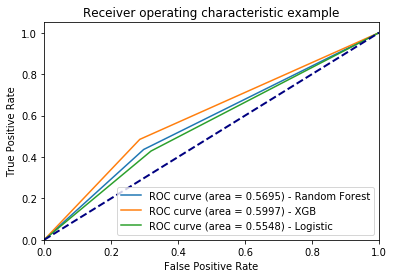

In [105]:
n_est = 100
perform_ml(X_train,X_test,y_train, y_test, n_est)

phase 2



Random Forest


actuals,Late,OnTime,All
predictions,,,
Late,2202,936,3138
OnTime,8251,22041,30292
All,10453,22977,33430


Correct Percentage: 0.72519

 Late Prediction Accuracy: 0.21066 
 Ontime Prediction Accuracy: 0.95926


,feature_values,feature_names
7,0.14,CRSArrTime
6,0.14,CRSDepTime
5,0.11,FlightNum
8,0.03,DistanceGroup
32,0.02,carrier_AA
35,0.01,carrier_DL
20,0.01,Humidity (%) avg
21,0.01,Humidity (%) low
30,0.01,Wind (mph) low
34,0.01,carrier_B6




XGB


actuals,Late,OnTime,All
predictions,,,
Late,2616,1213,3829
OnTime,7837,21764,29601
All,10453,22977,33430


Correct Percentage: 0.72929

 Late Prediction Accuracy: 0.25026 
 Ontime Prediction Accuracy: 0.94721


,feature_values,feature_names
7,0.12,CRSArrTime
6,0.11,CRSDepTime
5,0.11,FlightNum
3,0.06,DayofMonth
13,0.03,Temp. (°F) high
22,0.03,Sea Level Press. (in) high
8,0.03,DistanceGroup
4,0.03,DayOfWeek
19,0.03,Humidity (%) high
30,0.02,Wind (mph) low




Logistic


actuals,Late,OnTime,All
predictions,,,
Late,1782,774,2556
OnTime,8671,22203,30874
All,10453,22977,33430


Correct Percentage: 0.71747

 Late Prediction Accuracy: 0.17048 
 Ontime Prediction Accuracy: 0.96631


,feature_values,feature_names
180,0.38,snow_yes
14,0.37,Temp. (°F) avg
36,0.32,carrier_EV
22,0.23,Sea Level Press. (in) high
31,0.19,Precip. (in)
23,0.16,Sea Level Press. (in) avg
176,0.14,rain_yes
142,0.13,o_state_FL
34,0.11,carrier_B6
66,0.11,"o_city_Dallas, TX"


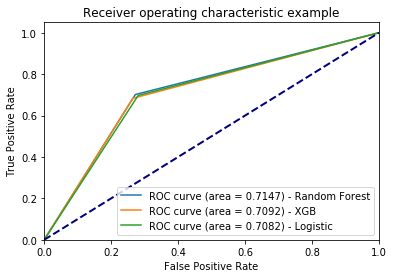

In [130]:
n_est = 100
perform_ml(X_train,X_test,y_train, y_test, n_est)

phase 3



Random Forest


actuals,Late,OnTime,All
predictions,,,
Late,2842,873,3715
OnTime,4878,15652,20530
All,7720,16525,24245


Correct Percentage: 0.76280

 Late Prediction Accuracy: 0.36813 
 Ontime Prediction Accuracy: 0.94717


,feature_values,feature_names
7,0.12,CRSArrTime
6,0.12,CRSDepTime
5,0.08,FlightNum
35,0.06,DepDelay_avg_origin
34,0.04,ArrDelay_avg_dest
33,0.04,DepDelay_avg_airline
32,0.03,ArrDelay_avg_airline
36,0.03,Seats
8,0.03,DistanceGroup
21,0.01,Humidity (%) low




XGB


actuals,Late,OnTime,All
predictions,,,
Late,3615,1494,5109
OnTime,4105,15031,19136
All,7720,16525,24245


Correct Percentage: 0.76907

 Late Prediction Accuracy: 0.46826 
 Ontime Prediction Accuracy: 0.90959


,feature_values,feature_names
35,0.11,DepDelay_avg_origin
7,0.10,CRSArrTime
6,0.09,CRSDepTime
5,0.09,FlightNum
32,0.05,ArrDelay_avg_airline
33,0.04,DepDelay_avg_airline
34,0.04,ArrDelay_avg_dest
3,0.03,DayofMonth
36,0.03,Seats
22,0.02,Sea Level Press. (in) high




Logistic


actuals,Late,OnTime,All
predictions,,,
Late,2858,1207,4065
OnTime,4862,15318,20180
All,7720,16525,24245


Correct Percentage: 0.74968

 Late Prediction Accuracy: 0.37021 
 Ontime Prediction Accuracy: 0.92696


,feature_values,feature_names
41,0.22,carrier_EV
39,0.14,carrier_B6
31,0.11,Precip. (in)
29,0.09,Wind (mph) avg
170,0.08,o_state_TX
183,0.08,snow_yes
69,0.07,"o_city_Dallas, TX"
179,0.07,rain_yes
117,0.06,"o_city_Raleigh/Durham, NC"
55,0.06,"o_city_Boston, MA"


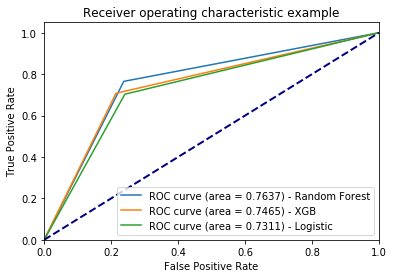

In [140]:
n_est = 100
perform_ml(X_train,X_test,y_train, y_test, n_est)

hyper paramter tuning

number of trees = 1


actuals,Late,OnTime,All
predictions,,,
Late,3550,1743,5293
OnTime,4170,14782,18952
All,7720,16525,24245


Correct Percentage: 0.75611

 Late Prediction Accuracy: 0.459844559585 
 OnTime Prediction Accuracy: 0.894523449319
number of trees = 10


actuals,Late,OnTime,All
predictions,,,
Late,3423,1402,4825
OnTime,4297,15123,19420
All,7720,16525,24245


Correct Percentage: 0.76494

 Late Prediction Accuracy: 0.443393782383 
 OnTime Prediction Accuracy: 0.915158850227
number of trees = 50


actuals,Late,OnTime,All
predictions,,,
Late,3566,1475,5041
OnTime,4154,15050,19204
All,7720,16525,24245


Correct Percentage: 0.76783

 Late Prediction Accuracy: 0.461917098446 
 OnTime Prediction Accuracy: 0.910741301059
number of trees = 100


actuals,Late,OnTime,All
predictions,,,
Late,3615,1494,5109
OnTime,4105,15031,19136
All,7720,16525,24245


Correct Percentage: 0.76907

 Late Prediction Accuracy: 0.468264248705 
 OnTime Prediction Accuracy: 0.909591527988
number of trees = 200


actuals,Late,OnTime,All
predictions,,,
Late,3690,1573,5263
OnTime,4030,14952,18982
All,7720,16525,24245


Correct Percentage: 0.76890

 Late Prediction Accuracy: 0.477979274611 
 OnTime Prediction Accuracy: 0.904810892587
number of trees = 250


actuals,Late,OnTime,All
predictions,,,
Late,3693,1574,5267
OnTime,4027,14951,18978
All,7720,16525,24245


Correct Percentage: 0.76898

 Late Prediction Accuracy: 0.478367875648 
 OnTime Prediction Accuracy: 0.904750378215


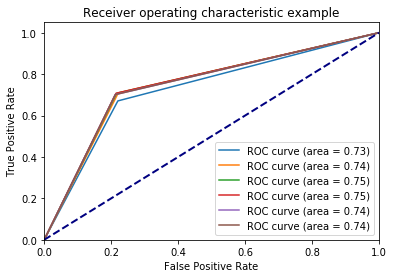

In [163]:
#rf
y_data = data_for_ml['ArrDel15']
X_data = data_for_ml.drop('ArrDel15', axis=1)
X_train, X_test = X_data[:round(0.8*X_data.shape[0])], X_data[round(0.8*X_data.shape[0]):]
y_train, y_test = np.array(y_data[:round(0.8*X_data.shape[0])]), np.array(y_data[round(0.8*X_data.shape[0]):])

perform_ml(X_train,X_test,y_train, y_test)

ensemble

In [175]:
def perform_ml(X_train, X_test, y_train, y_test, n_est):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost.sklearn import XGBClassifier
    from sklearn.metrics import accuracy_score, make_scorer
    from sklearn.model_selection import cross_validate, train_test_split
    from sklearn.metrics import classification_report, roc_curve, auc
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, VotingClassifier
    from xgboost.sklearn import XGBClassifier
    import matplotlib.pyplot as plt

    np.random.seed(42)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    model_1 = RandomForestClassifier(n_estimators= n_est, max_features= 'auto')
    model_2 = XGBClassifier(max_depth=10, n_estimators= n_est, reg_alpha=0.0, reg_lambda=0.5)
    model = VotingClassifier(estimators=[('rf', model_1), ('xgb', model_2)], voting='hard')

    for i in range(2):

        y_pred = model.fit(X_train,y_train).predict(X_test)
        actuals = pd.DataFrame(y_test)
        predictions = pd.DataFrame(y_pred)
        
        fpr[i], tpr[i], _ = roc_curve(y_pred, y_test, pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        actuals[actuals == 1] = "Late"
        actuals[actuals == 0] = "OnTime"

        predictions[predictions == 1] = "Late"
        predictions[predictions == 0] = "OnTime"
        
        global performance_matrix, table
        performance_matrix = pd.concat([predictions, actuals], axis =1)
        performance_matrix.columns = ['predictions', 'actuals']
        display(pd.crosstab(performance_matrix['predictions'], performance_matrix['actuals'], margins=True))
        table = pd.crosstab(performance_matrix['predictions'], performance_matrix['actuals'], margins=True)
        
        try:
            u_acc = table['Late']['Late']                               
            u_accratio = u_acc/table['Late']['All']
        except KeyError:
            u_acc = 0
            u_accratio = 0

        try:
            d_acc = table['OnTime']['OnTime']
            d_accratio = d_acc/table['OnTime']['All']
        except KeyError:
            d_acc = 0 
            d_accratio = 0


        correct = (d_acc+u_acc)/table['All']['All']
        print("Correct Percentage: %.5f" % round(float(correct),5))
        print ("\n", "Late Prediction Accuracy: %.5f" % u_accratio, "\n", "Ontime Prediction Accuracy: %.5f" %d_accratio)
        


    plt.figure()
    lw = 2
    for i, f in enumerate(fpr):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f)' % (roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

actuals,Late,OnTime,All
predictions,,,
Late,2641,657,3298
OnTime,5079,15868,20947
All,7720,16525,24245


Correct Percentage: 0.76342

 Late Prediction Accuracy: 0.34210 
 Ontime Prediction Accuracy: 0.96024


actuals,Late,OnTime,All
predictions,,,
Late,2610,652,3262
OnTime,5110,15873,20983
All,7720,16525,24245


Correct Percentage: 0.76234

 Late Prediction Accuracy: 0.33808 
 Ontime Prediction Accuracy: 0.96054


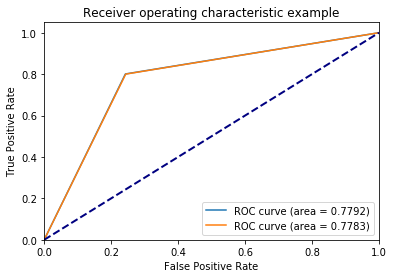

In [176]:
y_data = data_for_ml['ArrDel15']
X_data = data_for_ml.drop('ArrDel15', axis=1)
X_train, X_test = X_data[:round(0.8*X_data.shape[0])], X_data[round(0.8*X_data.shape[0]):]
y_train, y_test = np.array(y_data[:round(0.8*X_data.shape[0])]), np.array(y_data[round(0.8*X_data.shape[0]):])

perform_ml(X_train,X_test,y_train, y_test, 100)

phase 4: GRU

In [145]:
def gen_batch(X, y, batch_size, num_steps):
    
    features = X.shape[1]
    data_length = X.shape[0]

    raw_x = {}
    data_x = {}
    x = {}
    
    raw_y = y
    for k in range(features):
        raw_x[k] = X.iloc[:,k]
        
    batch_partition_length = data_length // batch_size
    
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for k in range(features):
        data_x[k] = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
        
    for i in range(batch_size):
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
        for k in range(features):
            data_x[k][i] = raw_x[k][batch_partition_length * i:batch_partition_length * (i + 1)]
    
    epoch_size = batch_partition_length // num_steps
        
    for i in range(epoch_size):
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        for k in range(features):
            x[k] = data_x[k][:, i * num_steps:(i + 1) * num_steps]
        x_final = np.asarray([x[k] for k in range(features)])
        yield (x_final, y)

def gen_epochs(X, y, num_steps, num_epochs):
    for i in range(num_epochs):
        yield gen_batch(X, y, batch_size, num_steps)
        
def build_basic_rnn_graph():
    
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, [num_features, batch_size, num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')

    x_new = tf.unstack(x, axis=0)
    x_new = tf.stack(x_new, axis=1)

    init_state = tf.zeros([batch_size, state_size])
    rnn_inputs = tf.unstack(x_new, axis=2)
    
    #cell = tf.contrib.rnn.BasicRNNCell(state_size)
    cell = tf.nn.rnn_cell.GRUCell(state_size)
    rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state,dtype=tf.float32)

    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
    predictions = [tf.nn.softmax(logit) for logit in logits]

    y_as_list = tf.unstack(y, num=num_steps, axis=1)
    losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
              logit, label in zip(logits, y_as_list)]
    total_loss = tf.reduce_mean(losses)

    train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)
    
    return dict(
        x = x,
        y = y,
        init_state = init_state,
        final_state = final_state,
        total_loss = total_loss,
        train_step = train_step,
        losses = losses,
        predictions = predictions,
        y_as_list = y_as_list
    )

def train_network(g, verbose=False, plot_g=True):
    
    tf.set_random_seed(2345)
    with tf.Session() as sess:
        
        global training_losses, test_losses

        sess.run(tf.global_variables_initializer())
        
        training_losses = []
        for _, epoch in enumerate(gen_epochs(X_train, y_train, num_steps, num_epochs)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_now, training_state, _ = sess.run([g['losses'],g['total_loss'],\
                                                                            g['final_state'],g['train_step']],
                                  feed_dict={g['x']: X, g['y']: Y, g['init_state']:training_state})
                training_loss += training_loss_now

                if step % batch_size == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/batch_size)
                    training_losses.append(training_loss/batch_size)
                    training_loss = 0

        if plot_g == True:
            plt.plot(training_losses)
            plt.show()
        
        test_losses = []
        ypred = []
        yactual = []
        for _, epoch in enumerate(gen_epochs(X_test, y_test, num_steps, 1)):
            test_loss = 0
            for step, (X, Y) in enumerate(epoch):
                pred, act, test_loss_now = sess.run([g['predictions'], g['y_as_list'], g['total_loss']],
                                  feed_dict={g['x']: X, g['y']: Y, g['init_state']:training_state})
                test_loss += test_loss_now
                ypred.append(pred)
                yactual.append(act)
                
                if step % batch_size == 0 and step > 0:
                    test_losses.append(test_loss/batch_size)
                    test_loss = 0
                                        

        l1, l2, l3 = np.squeeze(yactual).shape
        actuals = []
        predictions = []
        for x in range(l1):
            for y in range(l2):
                for z in range(l3):
                    predictions.append(ypred[x][y][z].argmax(axis=0))
                    actuals.append(yactual[x][y][z])

          
        global performance_matrix, predictions, actuals

        predictions = pd.DataFrame(predictions)
        actuals = pd.DataFrame(actuals)
        
        fpr, tpr, _ = roc_curve(predictions, actuals, pos_label=1)
        roc_auc = auc(fpr, tpr)
        
        actuals[actuals == 1] = "Late"
        actuals[actuals == 0] = "OnTime"

        predictions[predictions == 1] = "Late"
        predictions[predictions == 0] = "OnTime"

        performance_matrix = pd.concat([predictions, actuals], axis =1)
        performance_matrix.columns = ['predictions', 'actuals']
        display(pd.crosstab(performance_matrix['predictions'], performance_matrix['actuals'], margins=True))
        table = pd.crosstab(performance_matrix['predictions'], performance_matrix['actuals'], margins=True)

        try:
            u_acc = table['Late']['Late']                               
            u_accratio = u_acc/table['Late']['All']
        except KeyError:
            u_acc = 0
            u_accratio = 0

        try:
            d_acc = table['OnTime']['OnTime']
            d_accratio = d_acc/table['OnTime']['All']
        except KeyError:
            d_acc = 0 
            d_accratio = 0

        correct = (d_acc+u_acc)/table['All']['All']
        print("Correct Percentage: %.4f" % round(float(correct),4))
        print ("\n", "Late Prediction Accuracy:", u_accratio, "\n", "OnTime Prediction Accuracy:",d_accratio)       
        
        return fpr, tpr, roc_auc, training_losses[-1], test_losses[-1]

    
def analyse_rnn():
    
    print("num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs:", 
          num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    loss_while_training_list = []
    loss_while_test_list = []
    
    for i in range(1):
        g = build_basic_rnn_graph()
        fpr[i], tpr[i], roc_auc[i], loss_while_training, loss_while_test = train_network(g)
        loss_while_training_list.append(loss_while_training)
        loss_while_test_list.append(loss_while_test)    
        
    plt.figure()
    lw = 2
    for i, f in enumerate(fpr):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()  
    
    return np.mean(loss_while_training_list), np.mean(loss_while_test_list)

In [164]:
y_data = data_for_rnn['ArrDel15']
X_data = data_for_rnn.drop('ArrDel15', axis=1)
X_train, X_test = X_data[:round(0.8*X_data.shape[0])], X_data[round(0.8*X_data.shape[0]):]
y_train, y_test = np.array(y_data[:round(0.8*X_data.shape[0])]), np.array(y_data[round(0.8*X_data.shape[0]):])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96978, 27), (24244, 27), (96978,), (24244,))

In [165]:
X_train.columns

Index(['ArrDelaylag', 'DepDelaylag', 'TaxiOutlag', 'TaxiInlag',
       'ArrDelay_avg_airline', 'DepDelay_avg_airline', 'ArrDelay_avg_dest',
       'DepDelay_avg_origin', 'Temp. (°F) high', 'Temp. (°F) avg',
       'Temp. (°F) low', 'Dew Point (°F) high', 'Dew Point (°F) avg',
       'Dew Point (°F) low', 'Humidity (%) high', 'Humidity (%) avg',
       'Humidity (%) low', 'Sea Level Press. (in) high',
       'Sea Level Press. (in) avg', ' Sea Level Press. (in) low',
       'Visibility (mi) high', 'Visibility (mi) avg', 'Visibility (mi) low',
       'Wind (mph) high', 'Wind (mph) avg', 'Wind (mph) low', 'Precip. (in)'],
      dtype='object')

In [166]:
num_features = X_train.shape[1]
num_classes = 2
verbose = False
plot_g = True

Number of Epochs - Overfit vs Underfit

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 5


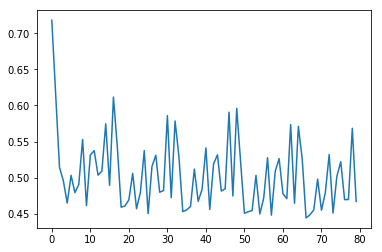

actuals,Late,OnTime,All
predictions,,,
Late,1925,870,2795
OnTime,5705,15500,21205
All,7630,16370,24000


Correct Percentage: 0.7260

 Late Prediction Accuracy: 0.252293577982 
 OnTime Prediction Accuracy: 0.946854001222


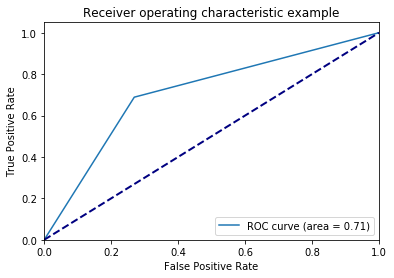

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 15


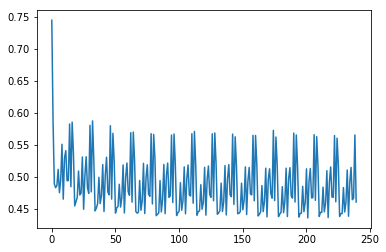

actuals,Late,OnTime,All
predictions,,,
Late,2687,1351,4038
OnTime,4943,15019,19962
All,7630,16370,24000


Correct Percentage: 0.7378

 Late Prediction Accuracy: 0.352162516383 
 OnTime Prediction Accuracy: 0.917470983506


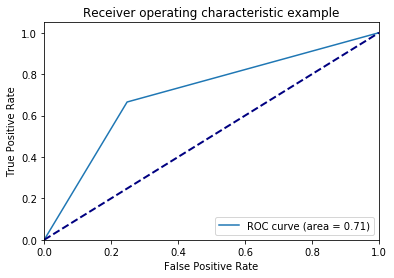

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 25


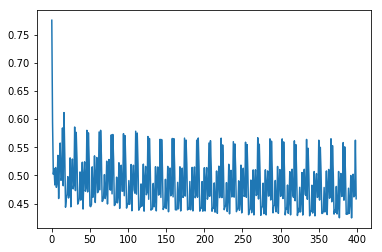

actuals,Late,OnTime,All
predictions,,,
Late,2328,891,3219
OnTime,5302,15479,20781
All,7630,16370,24000


Correct Percentage: 0.7420

 Late Prediction Accuracy: 0.305111402359 
 OnTime Prediction Accuracy: 0.945571166768


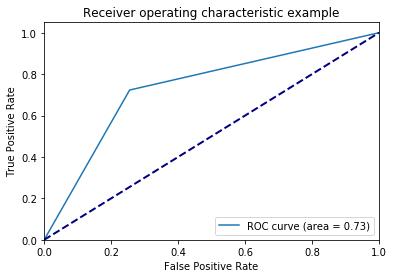

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 50


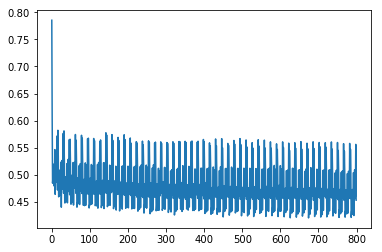

actuals,Late,OnTime,All
predictions,,,
Late,2488,1331,3819
OnTime,5142,15039,20181
All,7630,16370,24000


Correct Percentage: 0.7303

 Late Prediction Accuracy: 0.326081258191 
 OnTime Prediction Accuracy: 0.918692730605


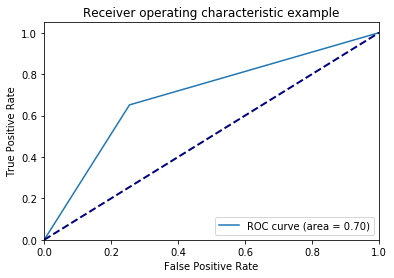

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 70


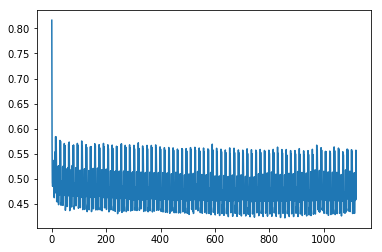

actuals,Late,OnTime,All
predictions,,,
Late,2376,1190,3566
OnTime,5254,15180,20434
All,7630,16370,24000


Correct Percentage: 0.7315

 Late Prediction Accuracy: 0.311402359109 
 OnTime Prediction Accuracy: 0.927306047648


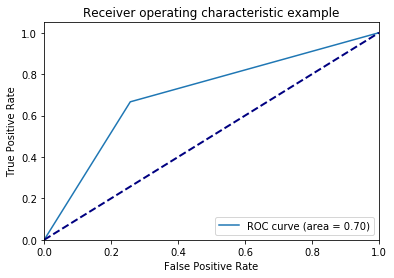

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 100


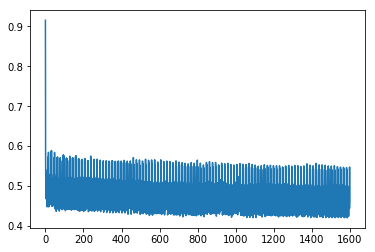

actuals,Late,OnTime,All
predictions,,,
Late,2633,1147,3780
OnTime,4997,15223,20220
All,7630,16370,24000


Correct Percentage: 0.7440

 Late Prediction Accuracy: 0.345085190039 
 OnTime Prediction Accuracy: 0.92993280391


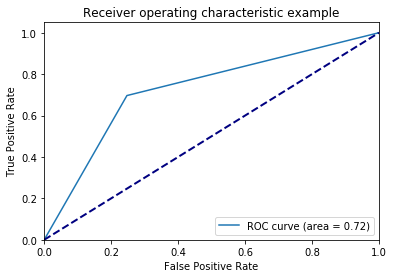

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 135


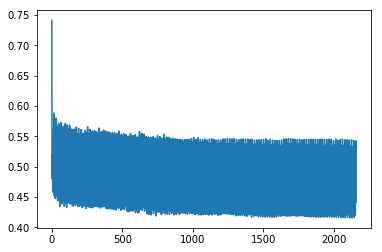

actuals,Late,OnTime,All
predictions,,,
Late,2114,770,2884
OnTime,5516,15600,21116
All,7630,16370,24000


Correct Percentage: 0.7381

 Late Prediction Accuracy: 0.277064220183 
 OnTime Prediction Accuracy: 0.952962736714


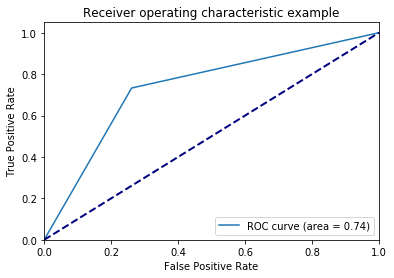

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 150


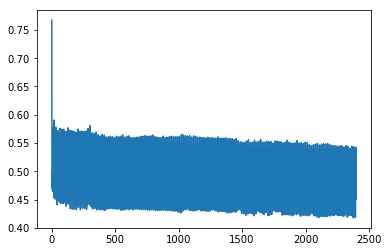

actuals,Late,OnTime,All
predictions,,,
Late,2151,802,2953
OnTime,5479,15568,21047
All,7630,16370,24000


Correct Percentage: 0.7383

 Late Prediction Accuracy: 0.281913499345 
 OnTime Prediction Accuracy: 0.951007941356


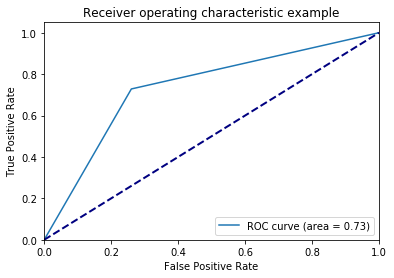

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 175


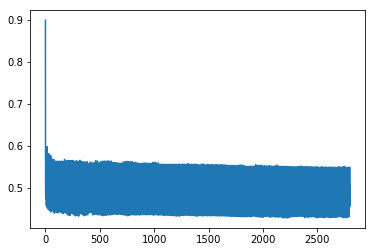

actuals,Late,OnTime,All
predictions,,,
Late,2954,1633,4587
OnTime,4676,14737,19413
All,7630,16370,24000


Correct Percentage: 0.7371

 Late Prediction Accuracy: 0.387155963303 
 OnTime Prediction Accuracy: 0.90024434942


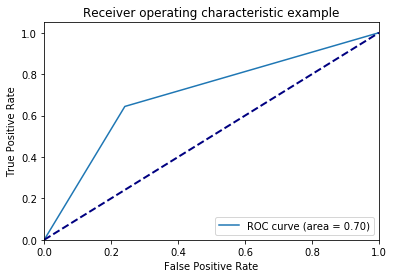

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 200


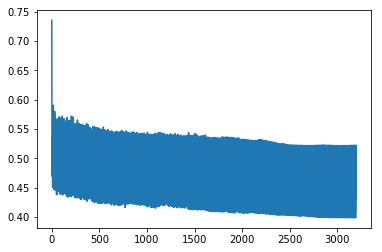

actuals,Late,OnTime,All
predictions,,,
Late,2917,1203,4120
OnTime,4713,15167,19880
All,7630,16370,24000


Correct Percentage: 0.7535

 Late Prediction Accuracy: 0.382306684142 
 OnTime Prediction Accuracy: 0.926511912034


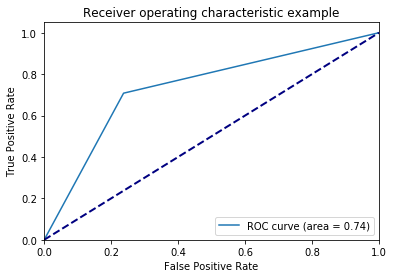

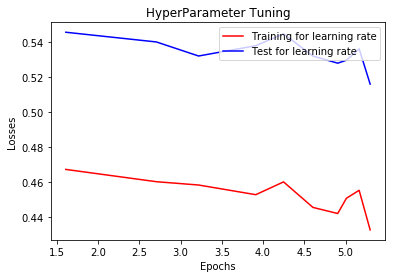

In [167]:
state_size = 40
num_steps = 60
batch_size = 10
learning_rate = 0.1
num_layers = 2
num_epochs = 50
loss_train_final =  []
loss_test_final = []

num_epochs_list = [5, 15, 25, 50, 70, 100, 135, 150, 175, 200]
for num_epochs in num_epochs_list:    
    tr_loss, te_loss = analyse_rnn()
    loss_train_final.append(tr_loss), loss_test_final.append(te_loss)
    
    
plt.figure()
lw = 2
plt.plot(np.log(num_epochs_list), loss_train_final, label='Training for learning rate',c='r')
plt.plot(np.log(num_epochs_list), loss_test_final, label='Test for learning rate',c='b')

plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('HyperParameter Tuning')
plt.legend(loc=1)
plt.show()  

Hyperparameter tuning - Learning rate here, explain the rest of parameters as well (num_steps, batch_size, state_size, learning_rate, num_layers)

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.0001 2 25


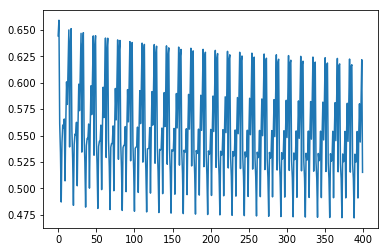

actuals,Late,OnTime,All
predictions,,,
Late,1943,2119,4062
OnTime,5687,14251,19938
All,7630,16370,24000


Correct Percentage: 0.6747

 Late Prediction Accuracy: 0.254652686763 
 OnTime Prediction Accuracy: 0.87055589493


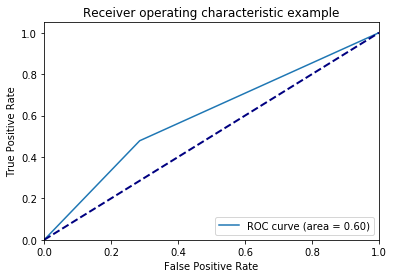

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.001 2 25


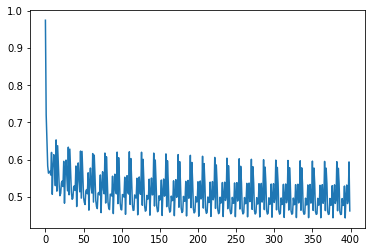

actuals,Late,OnTime,All
predictions,,,
Late,2041,1016,3057
OnTime,5589,15354,20943
All,7630,16370,24000


Correct Percentage: 0.7248

 Late Prediction Accuracy: 0.26749672346 
 OnTime Prediction Accuracy: 0.937935247404


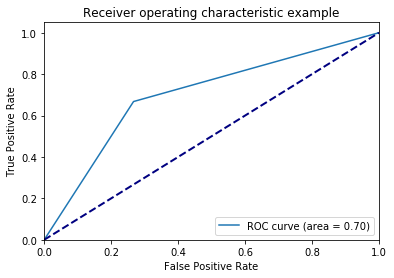

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.01 2 25


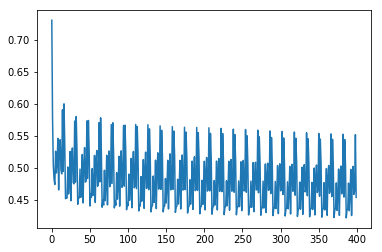

actuals,Late,OnTime,All
predictions,,,
Late,1951,725,2676
OnTime,5679,15645,21324
All,7630,16370,24000


Correct Percentage: 0.7332

 Late Prediction Accuracy: 0.255701179554 
 OnTime Prediction Accuracy: 0.955711667685


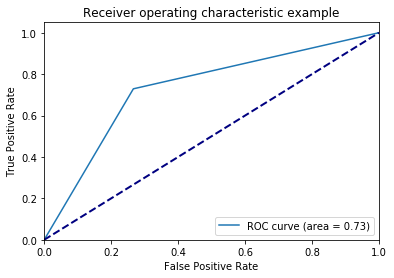

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 2 25


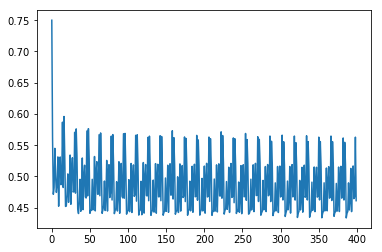

actuals,Late,OnTime,All
predictions,,,
Late,2115,833,2948
OnTime,5515,15537,21052
All,7630,16370,24000


Correct Percentage: 0.7355

 Late Prediction Accuracy: 0.277195281782 
 OnTime Prediction Accuracy: 0.949114233354


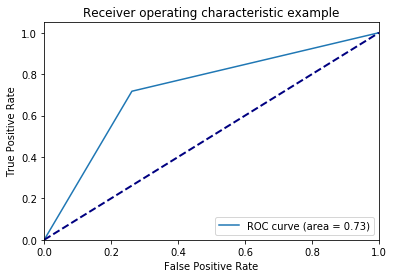

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 1 2 25


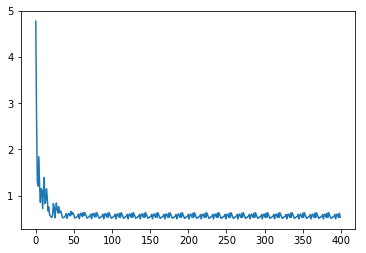

actuals,Late,OnTime,All
predictions,,,
OnTime,7630,16370,24000
All,7630,16370,24000


Correct Percentage: 0.6821

 Late Prediction Accuracy: 0 
 OnTime Prediction Accuracy: 1.0


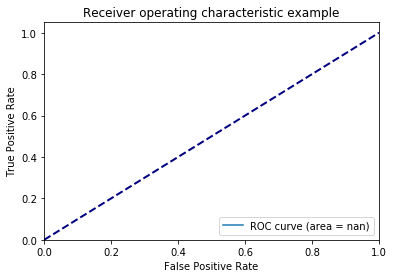

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 10 2 25


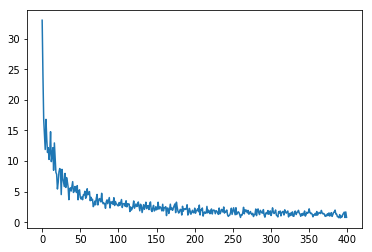

actuals,Late,OnTime,All
predictions,,,
Late,7630,16370,24000
All,7630,16370,24000


Correct Percentage: 0.3179

 Late Prediction Accuracy: 1.0 
 OnTime Prediction Accuracy: 0


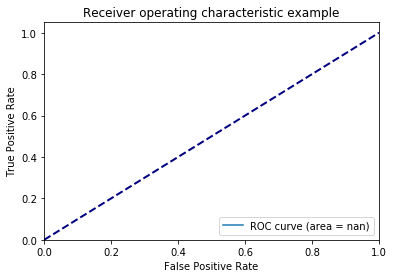

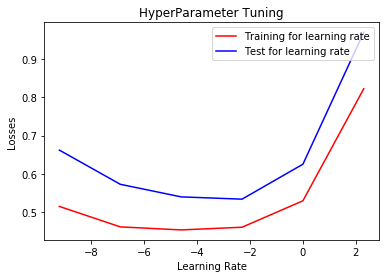

In [160]:
state_size = 40
num_steps = 60
batch_size = 10
learning_rate = 0.1
num_layers = 2
num_epochs = 25
loss_train_final =  []
loss_test_final = []

learning_rate_list = [0.0001, 0.001, 0.01, 0.1, 1, 10]
for learning_rate in learning_rate_list:    
    tr_loss, te_loss = analyse_rnn()
    loss_train_final.append(tr_loss), loss_test_final.append(te_loss)
    
plt.figure()
lw = 2
plt.plot(np.log(learning_rate_list), loss_train_final, label='Training for learning rate',c='r')
plt.plot(np.log(learning_rate_list), loss_test_final, label='Test for learning rate',c='b')

plt.xlabel('Learning Rate')
plt.ylabel('Losses')
plt.title('HyperParameter Tuning')
plt.legend(loc=1)
plt.show()  

Final model

num_steps, batch_size, state_size, learning_rate, num_layers, num_epochs: 60 10 40 0.1 5 50


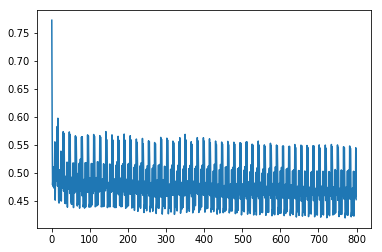

actuals,Late,OnTime,All
predictions,,,
Late,2410,907,3317
OnTime,5220,15463,20683
All,7630,16370,24000


Correct Percentage: 0.7447

 Late Prediction Accuracy: 0.315858453473 
 OnTime Prediction Accuracy: 0.94459376909


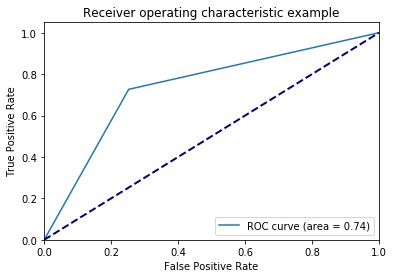

(0.45264248847961425, 0.5248736649751663)

In [161]:
state_size = 40
num_steps = 60
batch_size = 10
learning_rate = 0.1
num_layers = 5
num_epochs = 50
analyse_rnn()